In [1]:
import os
import time
import warnings
from bs4 import BeautifulSoup
from selenium import webdriver
from dotenv import load_dotenv
from readability import Document
# from langchain_groq import ChatGroq
from langgraph.graph import MessagesState
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from embedding_search.parsing_docs import docx_parser
from langchain_core.prompts import ChatPromptTemplate
from embedding_search.embedding import chunk_retriever
from webdriver_manager.chrome import ChromeDriverManager
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.document_loaders import WikipediaLoader
from langchain_community.tools.tavily_search import TavilySearchResults

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="Install Nomic's megablocks fork*")

In [2]:
load_dotenv()

# groq_api_key = os.getenv('GROQ_API_KEY')
travily_api_key = os.getenv('TAVILY_API_KEY')
google_api_key = os.getenv('GOOGLE_API_KEY')

In [3]:
# llm = ChatGroq(model="llama-3.3-70b-versatile")
llm = ChatGoogleGenerativeAI(model='gemini-2.5-flash')

In [4]:
from typing import Literal, Optional
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

class GraphSchema(MessagesState): 
    chunks: list
    user_query: str
    rag_search: str
    sub_queries: list
    retrieved_chunks: str
    normalized_query: str
    combined_summary: str
    web_search_results: str
    wikipedia_search_results: str
    human_feedback: Optional[str] = None
    feedback_sentiment: Optional[Literal['positive', 'negative']] = None

In [5]:
## Prompt for query normalization
normalization_prompt = ChatPromptTemplate.from_messages(
    [
        ("system",
         """You are a query-rewriting system.
         Your task is to rewrite the user's input into a precise, domain-specific, and technical search query suitable for general web search engines and Wikipedia.
         Instructions:
         1. Preserve the original intent exactly. Do not add new goals or assumptions.
         2. Use correct technical terminology where appropriate.
         3. Replace vague or conversational language with formal, technical phrasing.
         4. Expand abbreviations only if unambiguous.
         5. Prefer nouns and noun phrases over full sentences.
         6. Remove personal pronouns, filler words, and rhetorical phrasing.
         7. Do not include opinions, explanations, or answers.
         8. Do not fabricate facts, dates, names, or relationships.
         9. If the domain is unclear, rewrite the query in the most neutral technical form possible.
         10. Output only the rewritten query, nothing else."""),

        ("human", 'user_query:"{query}"')
    ]
)

## Prompt for feedback-based query normalization
feedback_query_normalization_prompt = ChatPromptTemplate.from_messages(
    [
        ("system",
         """You are a query-refinement system. Your task is to take:
            1. A previously normalized technical search query, and
            2. Explicit user feedback about what to adjust, add, remove, or emphasize, and produce a revised normalized query that incorporates the feedback precisely.

            Instructions:
            1. Preserve the original search intent unless the feedback explicitly changes it.
            2. Apply only the modifications explicitly stated in the feedback.
            3. Use formal, domain-specific, and technical terminology.
            4. Maintain a neutral, factual tone.
            5. Prefer concise noun phrases over full sentences.
            6. Remove ambiguity, redundancy, and conversational language.
            7. Do not introduce new constraints, facts, entities, or assumptions.
            8. Do not fabricate terminology, dates, or relationships.
            9. If feedback conflicts with the original query, prioritize the feedback.
            10. If feedback is unclear or non-actionable, make the minimal safe adjustment.
            11. Compare the revised query against the previous one and the user feedback to ensure nothing new search query is introduced.
            12. Keep the revised query as concise and specific as possible.
            13. Output only the revised rewritten query, nothing else."""),

        ('human',
         'Previous normalized query:"{previous_normalized_query}"'
         'User Feedback:"{user_feedback}"'
        )
    ]
)


## defining node function for query normalization
def query_normalization(state:GraphSchema):
    if (state.get('feedback_sentiment', None) is None) and (state.get('human_feedback', None) is None):
        final_prompt = normalization_prompt.format(query=state['user_query'])
        query = llm.invoke(input=final_prompt).content
        return {'normalized_query': query.strip('"')}

    elif (state.get('feedback_sentiment', None) == 'negative') and (state.get('human_feedback', None) is not None):
        final_prompt = feedback_query_normalization_prompt.format(
            previous_normalized_query=state['normalized_query'],
            user_feedback=state['human_feedback']
        )
        query = llm.invoke(input=final_prompt).content
        print('normalized query:', query.strip('"'))
        return {'normalized_query': query.strip('"')}


## Prompt for decomposing search query into sub-queries
search_sub_queries_prompt = ChatPromptTemplate(
    [
        ('system',
         """You are a query decomposition engine. Your task is to break down the provided normalised search query into different sub-querys following the below instructions.
            Instructions:

            1. Identify all distinct topics, entities, or concepts explicitly present in the query.
            2. Generate the minimal number of sub-queries required to cover the query.
            3. If the query represents a single coherent topic, output exactly one sub-query.
            4. Each sub-query must be independently searchable without relying on shared or repeated context.
            5. Do not repeat common context, qualifiers, or entities across multiple sub-queries unless strictly required for clarity.
            6. Preserve the original wording and terminology as much as possible.
            7. Do not infer intent or add information not explicitly stated.
            8. Do not merge unrelated concepts into a single sub-query.
            9. Prefer concise noun phrases over full sentences.
            10. Use precise technical terminology where applicable.
            11. Remove conversational language, personal pronouns, and filler words.
            12. Deduplicate semantically equivalent sub-queries.
            13. Output only the sub-queries, one per line, with no additional text.
            
            normalized search query: "{normalized_query}" """)
    ]
)


## Function definition for decomposing search query into sub-queries and user preference for RAG search
def perform_rag_search(state:GraphSchema):
    sub_queries_prompt = search_sub_queries_prompt.format(normalized_query=state['normalized_query'])
    decomposed_sub_queries = llm.invoke(input=sub_queries_prompt).content.split('\n')
    print('Decomposed sub-queries:', decomposed_sub_queries)
    user_preference = str(input("Do you want to perform RAG search? (Yes/No): "))
    if user_preference.lower() in ['yes', 'y']:
        return {'rag_search': 'Yes', 'sub_queries': decomposed_sub_queries}
    elif user_preference.lower() in ['no', 'n']:
        return {'rag_search': 'No', 'sub_queries': decomposed_sub_queries}


## function for chunking the docx file
def chunk_docx(state:GraphSchema):
    chunk = docx_parser(file_path='D:/Study Material/Docs/Lithium-Ion_Batteries_in_Electric_Vehicles.docx')
    return {'chunks': chunk}


## function to perform internal document search
def internal_search(state:GraphSchema):
    if state['rag_search'] == 'Yes':
        docs = chunk_docx(state=state)['chunks']
        rag_search = ''

        for sub_query in state['sub_queries']:      
            similar_chunk = chunk_retriever(chunks=docs, query=sub_query)
            rag_search += similar_chunk + "\n\n-------------------------------\n\n"
     
        return {'retrieved_chunks': [rag_search]}
    else:
        return {'retrieved_chunks': []}


## defining node function for web search
tavily_search = TavilySearchResults(max_results=3)


## function to fetch and clean text from a web page using Selenium and Readability
def fetch_clean_text(url: str) -> str:

    options = Options()
    options.add_argument("--headless=new")
    options.add_argument("--disable-gpu")
    options.add_argument("--no-sandbox")

    service = Service(ChromeDriverManager().install())
    driver = webdriver.Chrome(service=service, options=options)

    try:
        driver.get(url)
        time.sleep(3)

        html = driver.page_source
        doc = Document(html)
        main_html = doc.summary(html_partial=True)
        soup = BeautifulSoup(main_html, "html.parser")
        for tag in soup(["script", "style", "nav", "footer", "aside"]):
            tag.decompose()
        text = soup.get_text(strip=True, separator=" ")
        return text
    
    except Exception as ex:
        print('Error message:', str(ex))
        return 'Error fetching web page content.'

    finally:
        driver.quit()


def web_search(state:GraphSchema):
    search_results = ''

    for sub_query in state['sub_queries']:
        web_search = tavily_search.invoke(input=sub_query)
        formatted_search_docs = "\n\n-------------------------------\n\n".join(
            [
                f'Document url - "{doc["url"]}"\nDocument title - {doc["title"]}\nDocument content - {fetch_clean_text(url=doc["url"])}'
                for doc in web_search
            ]
        )
        search_results += formatted_search_docs + "\n\n-------------------------------\n\n"
    
    return {'web_search_results':[search_results]}


## defining node functionality for wikipedia search
def wikipedia_search(state:GraphSchema):
    wiki_results = ''

    for sub_query in state['sub_queries']:
        wiki_loader = WikipediaLoader(query=sub_query, load_max_docs=3).load()
        
        formatted_wiki_docs = "\n\n-------------------------------\n\n".join(
            [
                f'Document url - "{doc.metadata["source"]}"\nDocument title - {doc.metadata["title"]}\nDocument Summary - {doc.metadata["summary"]}'
                for doc in wiki_loader
            ]
        )
        wiki_results += formatted_wiki_docs + "\n\n-------------------------------\n\n"
    
    return {'wikipedia_search_results':[wiki_results]}


## final result generation node function
summarization_prompt = ChatPromptTemplate.from_messages(
    [
        ('system',
         """You are a synthesis assistant. Your task is to synthesize the below provided content into a single, coherent output following the instructions.
            Instructions:

            1. Use ONLY the evidence content provided below to generate the final results.
            2. Do not add new information, interpretations, assumptions, background knowledge, or external facts.
            3. Based on the provided content, generate the summary with three sections: Introduction, Findings, and Conclusion with sections and sub-sections as needed.
            4. List all the refrences at last of the summary. Mark unknown references as 'internal document', if any.
            5. Summarise the content in a concise, clear, and structured manner."""
        ),

        ('system', '{contents}'),
        ('human', '{user_query}')
    ]
)


def content_synthesis(state:GraphSchema):
    combined_contents = "\n\n-------------------------------\n\n".join(
        state['web_search_results'] + state['wikipedia_search_results'] + state['retrieved_chunks']
    )

    summarization_formatted_prompt = summarization_prompt.format(
        contents=combined_contents,
        user_query=state['user_query']
    )

    final_response = llm.invoke(input=summarization_formatted_prompt).content
    print('Summary:', final_response)
    return {'combined_summary': final_response}


def feedback_collection(state:GraphSchema):
    feedback_sentiment = input("Is the provided summary good enough? (yes/no): ")
    if feedback_sentiment.lower() in ['yes', 'y']:
        return {'human_feedback': 'The generated summary is good.', 'feedback_sentiment': 'positive'}
    else:
        user_feedback = input("Kindly provide the modification you want in the generated summary: ")
        return {'human_feedback': user_feedback, 'feedback_sentiment': 'negative'}


## defining conditional function for query normalization
def needs_query_normalization(state:GraphSchema):
    if (state.get('feedback_sentiment',None) == 'negative') and (state.get('human_feedback',None) is not None):
        return 'query_normalization'
    return END

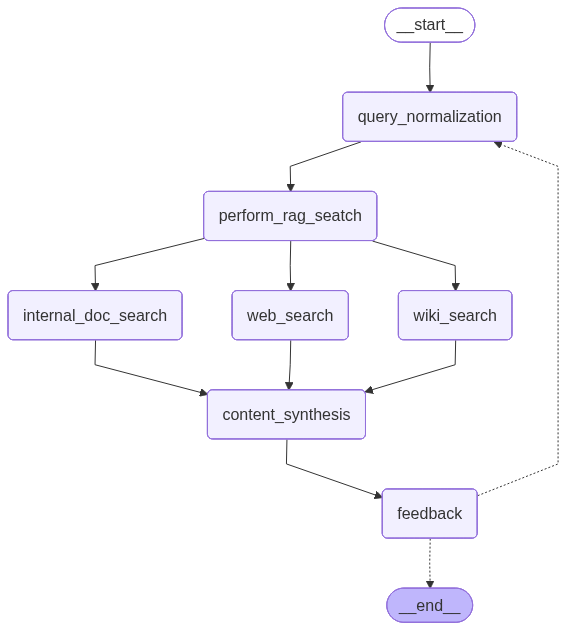

In [6]:
builder = StateGraph(state_schema=GraphSchema)
builder.add_node(node='query_normalization', action=query_normalization)
builder.add_node(node='perform_rag_seatch', action=perform_rag_search)
builder.add_node(node='web_search', action=web_search)
builder.add_node(node='wiki_search', action=wikipedia_search)
builder.add_node(node='internal_doc_search', action=internal_search)
builder.add_node(node='content_synthesis', action=content_synthesis)
builder.add_node(node='feedback', action=feedback_collection)

builder.add_edge(start_key=START, end_key='query_normalization')
builder.add_edge(start_key='query_normalization', end_key='perform_rag_seatch')
builder.add_edge(start_key='perform_rag_seatch', end_key='web_search')
builder.add_edge(start_key='perform_rag_seatch', end_key='wiki_search')
builder.add_edge(start_key='perform_rag_seatch', end_key='internal_doc_search')
builder.add_edge(start_key='web_search', end_key='content_synthesis')
builder.add_edge(start_key='wiki_search', end_key='content_synthesis')
builder.add_edge(start_key='internal_doc_search', end_key='content_synthesis')
builder.add_edge(start_key='content_synthesis', end_key='feedback')
builder.add_conditional_edges(source='feedback', path=needs_query_normalization, path_map=['query_normalization', END])

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
graph.invoke(input={'user_query': 'advantages of lithium-ion batteries and its thermal runaway.'})

Decomposed sub-queries: ['Lithium-ion battery advantages', 'Lithium-ion battery thermal runaway']
Summary: ## Summary of Lithium-Ion Batteries: Advantages and Thermal Runaway

### Introduction

Lithium-ion (Li-ion) batteries are fundamental to modern technology, powering a wide array of devices from portable electronics and electric vehicles to grid energy storage systems. Their widespread adoption is attributed to significant advantages such as high energy density, rapid charging capabilities, long lifespan, and low self-discharge rates. The invention and commercialization of Li-ion batteries, recognized by the 2019 Nobel Prize in Chemistry, have profoundly impacted technology. However, their use comes with critical safety concerns, primarily the phenomenon of thermal runaway, which can lead to fires, explosions, and the release of harmful emissions.

### Findings

#### Advantages of Lithium-Ion Batteries

Lithium-ion batteries offer several key benefits that make them a preferred cho

{'messages': [],
 'user_query': 'advantages of lithium-ion batteries and its thermal runaway.',
 'rag_search': 'Yes',
 'sub_queries': ['Lithium-ion battery advantages',
  'Lithium-ion battery thermal runaway'],
 'retrieved_chunks': ['Advantages of Lithium-Ion Batteries: When you pick a lithium-ion battery for your phone, laptop, or car, you think about some important things. Lithium-ion batteries hold a lot of energy, charge quickly, and last a long time. This makes them common in electronics and vehicles. The advantages of Lithium-Ion batteries are listed below:\\nHigh energy density\\xa0- Lithium-ion batteries can hold a lot of energy. They fit more power into a small space. This helps your phone or laptop last longer. Most lithium-ion batteries store between\\xa0150 and 300 Wh/kg. New models can go over 250 Wh/kg. Future batteries may hold even more. Nickel-metal hydride and lead-acid batteries have less energy density. More energy density means lighter devices and\\xa0longer uses. 